In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

Using TensorFlow backend.


In [2]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.set_random_seed(1337)

In [3]:
df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
df_train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# Preprocessing

In [4]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


## Remove Nan (0 vehicle)

In [5]:
train = train.fillna(0)

## Normalize the data on 0, 1

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
train[train.columns] = scaler.fit_transform(train[train.columns])

In [9]:
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-06-30 19:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.562914,0.638298,0.150838,0.444444


# Generate rolling forecast features

In [10]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [11]:
nb_forecast_per_junction

2952

In [12]:
nb_forecast_per_junction * 4

11808

That will certainly not fit in the GPU VRAM --> We will get inspiration from seq2seq models and do a sliding window of time that matches a week.

In [13]:
num_feats = 4
seq_len = 24 * 7 # We predict a week
num_outputs = 4
num_hidden = 2 # We keep two weeks
bs = 1024
epochs = 100
LOG_PATH = "checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"seq2seq-attns-not-stateful.hdf5"


# pred_len = int(nb_forecast_per_junction / seq_len)
# assert nb_forecast_per_junction % seq_len == 0 # Check that we can split forecast into even sequences
# print(pred_len)

We originally had 14592 rows, we will generate sequences of predictions from it.

In [14]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [15]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Loss function

In [16]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## Neural net

In [17]:
from keras.optimizers import adam, rmsprop

In [18]:
# adam = adam(clipvalue=0.5) # Clip to avoid exploding gradients
rmsprop = rmsprop(lr = 0.005, decay = 0.05)

In [19]:
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.models import *
from keras.activations import *

In [20]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    
    # We compute the attention over the seq_len
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1))(inputs)
    avg = SeparableConv2D(feats_depth, (1,1))(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1))(avg)
    
    
    a_probs = Permute((2, 1), name='attn_' + str(days_ago) + '_days')(avg)
    # out = Multiply(name='attn_mul_'+ str(days_ago) +'_days')([inputs, a_probs])
    out = Concatenate(name='attention_cat_'+ str(days_ago) +'_days')([inputs, a_probs])
    return out

In [21]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input(batch_shape=(bs, seq_len, num_feats))

    # Encoder RNNs
    enc = GRU(seq_len,
              return_sequences=True,
              stateful=True)(x)
    
    # Attention decoders
    attention_1d = attention_n_days_ago(enc, 1)
    attention_1w = attention_n_days_ago(enc, 7)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_6m = attention_n_days_ago(enc, 184)
    attention_1y = attention_n_days_ago(enc, 365)
    
    att = Concatenate(name='attns_cat', axis = 1)([attention_1d,
                                                   attention_1w,
                                                   attention_1m,
                                                   attention_1q,
                                                   attention_6m,
                                                   attention_1y])
    
    # How to merge? concat, mul, add, use Dense Layer or Depthwise convolution ?
    att = Permute((2, 1))(att)
    
    # Experimental, use depthwise convolution to merge all those layers
    att = Lambda(lambda x: K.expand_dims(x, axis = 1))(att)
    att = SeparableConv2D(seq_len, (1,1))(att)
    att = Lambda(lambda x: K.squeeze(x, 1))(att)
    
    
    # att = Dense(seq_len, activation=None)(att)
    # att = Lambda(lambda x: softmax(x, axis = 1))(att) # Flatten along the concat axis
    
    # Decoder RNN
    dec = GRU(num_hidden,
              return_sequences=False,
              stateful = True)(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs, activation=None)(dec) # no activation for regression
    
    model = Model(inputs=x, outputs=out)
                          
    model.compile(loss= root_mean_squared_error, optimizer= rmsprop)
    return model

In [22]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 4)       0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 168, 168)     87192       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 168, 168)  0           gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1, 168, 168)  0           gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_5 (

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Callbacks

In [24]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping

In [25]:
history = History()
checkpointer = ModelCheckpoint(filepath= LOG_PATH,
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

# Training

In [26]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          shuffle=False,
          callbacks=[history,checkpointer,csv_logger,early_stop])

Train on 12331 samples, validate on 650 samples
Epoch 1/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.1105Epoch 00001: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.1108 - val_loss: 0.1430
Epoch 2/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0784Epoch 00002: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0785 - val_loss: 0.0986
Epoch 3/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0818Epoch 00003: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0819 - val_loss: 0.1001
Epoch 4/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0708Epoch 00004: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf

Epoch 9/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0526Epoch 00009: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0527 - val_loss: 0.0789
Epoch 10/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0514Epoch 00010: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0515 - val_loss: 0.0783
Epoch 11/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0503Epoch 00011: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0504 - val_loss: 0.0777
Epoch 12/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0493Epoch 00012: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [=============================

Epoch 17/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0466Epoch 00017: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0467 - val_loss: 0.0741
Epoch 18/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0462Epoch 00018: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0463 - val_loss: 0.0735
Epoch 19/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0459Epoch 00019: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0460 - val_loss: 0.0730
Epoch 20/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0455Epoch 00020: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 25/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0443Epoch 00025: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0444 - val_loss: 0.0702
Epoch 26/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0441Epoch 00026: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0442 - val_loss: 0.0699
Epoch 27/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0439Epoch 00027: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0440 - val_loss: 0.0696
Epoch 28/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0437Epoch 00028: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 33/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0430Epoch 00033: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0431 - val_loss: 0.0681
Epoch 34/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0428Epoch 00034: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0429 - val_loss: 0.0679
Epoch 35/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0427Epoch 00035: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0428 - val_loss: 0.0677
Epoch 36/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0426Epoch 00036: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 41/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0421Epoch 00041: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0422 - val_loss: 0.0667
Epoch 42/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0420Epoch 00042: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0421 - val_loss: 0.0666
Epoch 43/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0419Epoch 00043: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0420 - val_loss: 0.0664
Epoch 44/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0418Epoch 00044: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 49/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0415Epoch 00049: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0416 - val_loss: 0.0657
Epoch 50/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0414Epoch 00050: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0415 - val_loss: 0.0656
Epoch 51/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0413Epoch 00051: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0414 - val_loss: 0.0655
Epoch 52/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0413Epoch 00052: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 57/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0410Epoch 00057: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0411 - val_loss: 0.0650
Epoch 58/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0410Epoch 00058: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0411 - val_loss: 0.0649
Epoch 59/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0409Epoch 00059: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0410 - val_loss: 0.0648
Epoch 60/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0409Epoch 00060: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 65/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0407Epoch 00065: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0407 - val_loss: 0.0644
Epoch 66/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0406Epoch 00066: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0407 - val_loss: 0.0643
Epoch 67/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0406Epoch 00067: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0407 - val_loss: 0.0643
Epoch 68/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0405Epoch 00068: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 73/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0404Epoch 00073: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0405 - val_loss: 0.0639
Epoch 74/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0403Epoch 00074: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0404 - val_loss: 0.0638
Epoch 75/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0403Epoch 00075: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0404 - val_loss: 0.0638
Epoch 76/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0403Epoch 00076: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 81/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0401Epoch 00081: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0402 - val_loss: 0.0635
Epoch 82/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0401Epoch 00082: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0402 - val_loss: 0.0634
Epoch 83/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0401Epoch 00083: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0402 - val_loss: 0.0634
Epoch 84/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0401Epoch 00084: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 89/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0399Epoch 00089: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0400 - val_loss: 0.0631
Epoch 90/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0399Epoch 00090: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0400 - val_loss: 0.0631
Epoch 91/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0399Epoch 00091: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0400 - val_loss: 0.0630
Epoch 92/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0399Epoch 00092: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [============================

Epoch 97/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0398Epoch 00097: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0399 - val_loss: 0.0628
Epoch 98/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0398Epoch 00098: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0398 - val_loss: 0.0627
Epoch 99/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0397Epoch 00099: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0398 - val_loss: 0.0627
Epoch 100/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0397Epoch 00100: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [===========================

Epoch 105/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0396Epoch 00105: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0397 - val_loss: 0.0625
Epoch 106/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0396Epoch 00106: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0397 - val_loss: 0.0624
Epoch 107/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0396Epoch 00107: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0397 - val_loss: 0.0624
Epoch 108/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0396Epoch 00108: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 113/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0395Epoch 00113: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0396 - val_loss: 0.0622
Epoch 114/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0395Epoch 00114: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0396 - val_loss: 0.0622
Epoch 115/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0395Epoch 00115: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0396 - val_loss: 0.0622
Epoch 116/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0395Epoch 00116: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 121/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0394Epoch 00121: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0395 - val_loss: 0.0620
Epoch 122/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0394Epoch 00122: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0395 - val_loss: 0.0620
Epoch 123/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0394Epoch 00123: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0395 - val_loss: 0.0619
Epoch 124/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0394Epoch 00124: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 129/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0393Epoch 00129: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0394 - val_loss: 0.0618
Epoch 130/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0393Epoch 00130: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0394 - val_loss: 0.0618
Epoch 131/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0393Epoch 00131: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0394 - val_loss: 0.0617
Epoch 132/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0393Epoch 00132: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 137/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0392Epoch 00137: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0393 - val_loss: 0.0616
Epoch 138/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0392Epoch 00138: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0393 - val_loss: 0.0616
Epoch 139/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0392Epoch 00139: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0393 - val_loss: 0.0616
Epoch 140/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0392Epoch 00140: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 145/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0391Epoch 00145: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0392 - val_loss: 0.0615
Epoch 146/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0391Epoch 00146: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0392 - val_loss: 0.0614
Epoch 147/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0391Epoch 00147: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0392 - val_loss: 0.0614
Epoch 148/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0391Epoch 00148: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 153/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0390Epoch 00153: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0391 - val_loss: 0.0613
Epoch 154/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0390Epoch 00154: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0391 - val_loss: 0.0613
Epoch 155/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0390Epoch 00155: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0391 - val_loss: 0.0613
Epoch 156/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0390Epoch 00156: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 161/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0390Epoch 00161: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0390 - val_loss: 0.0612
Epoch 162/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00162: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0390 - val_loss: 0.0612
Epoch 163/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00163: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0390 - val_loss: 0.0612
Epoch 164/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00164: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 169/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00169: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0390 - val_loss: 0.0611
Epoch 170/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00170: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0390 - val_loss: 0.0611
Epoch 171/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00171: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0389 - val_loss: 0.0611
Epoch 172/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0389Epoch 00172: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 177/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00177: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0389 - val_loss: 0.0611
Epoch 178/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00178: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0389 - val_loss: 0.0611
Epoch 179/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00179: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0389 - val_loss: 0.0611
Epoch 180/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00180: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 185/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00185: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 186/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0388Epoch 00186: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 187/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00187: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 188/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00188: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 193/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00193: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 194/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00194: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 195/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00195: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0388 - val_loss: 0.0610
Epoch 196/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00196: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 201/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0387Epoch 00201: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 202/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00202: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 203/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00203: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 204/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00204: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 209/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00209: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 210/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00210: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 211/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00211: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0387 - val_loss: 0.0609
Epoch 212/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00212: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 217/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00217: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 218/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0386Epoch 00218: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 219/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00219: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 220/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00220: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 225/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00225: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 226/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00226: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 227/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00227: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 228/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00228: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 233/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00233: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0386 - val_loss: 0.0608
Epoch 234/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00234: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0608
Epoch 235/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00235: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 236/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0385Epoch 00236: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 241/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00241: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 242/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00242: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 243/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00243: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 244/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00244: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

Epoch 249/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00249: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 250/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00250: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 251/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00251: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0385 - val_loss: 0.0607
Epoch 252/500

12288/12331 [============================>.] - ETA: 0s - loss: 0.0384Epoch 00252: saving model to checkpoints/2017-11-18_2053-seq2seq-attns-not-stateful.hdf5

12331/12331 [========================

KeyboardInterrupt: 

# Saving RNN states

In [27]:
def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]

def set_states(model, states):
    for (d,_), s in zip(model.state_updates, states):
        K.set_value(d, s)

In [28]:
RNNs_states = get_states(model)

# Validation

## Validation by feeding truth values

In [29]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'blue', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'orange', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

### Prediction

In [31]:
set_states(model, RNNs_states)

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_pred.shape

(1442, 4)

### Plot & score

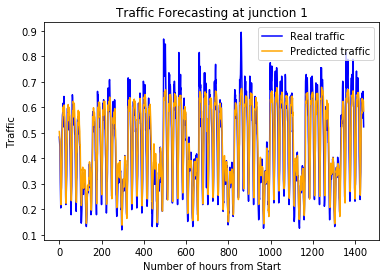

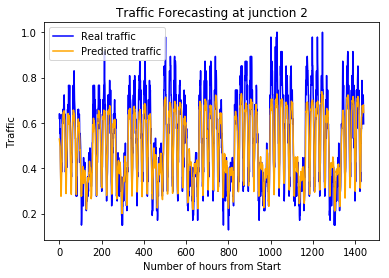

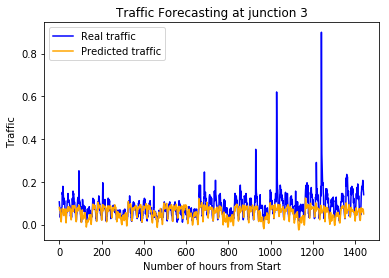

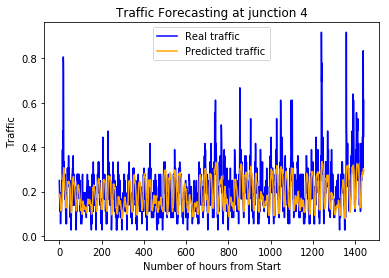

In [34]:
plot_preds(y_test, y_pred)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [36]:
rmse(y_test, y_pred)

0.07471244126038537

## Validation by feeding predicted values

In [37]:
def pred_seq(model, to_pred, window_size):
    num_preds = to_pred.shape[0]
    current = to_pred[0]
    predicted = []
    for i in range(num_preds):
        predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
        current = current[1:]
        current = np.insert(current, [window_size-1], predicted[-1], axis=0)
    return np.asarray(predicted)

### Predictions

In [39]:
set_states(model, RNNs_states)

In [ ]:
seqpreds = pred_seq(model, X_test, seq_len)

In [ ]:
seqpreds.shape

### Plot & score

In [ ]:
plot_preds(y_test, seqpreds)

In [ ]:
rmse(y_test, seqpreds)